<a href="https://colab.research.google.com/github/amutharun/RAG/blob/main/RAG_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Evaluation Notebook


### The Problem -

The primary challenge we face working with Large Language models, revolve around **trust**. </br>

*How do we trust the answer provided by a RAG application?*</br>
*How do we ensure that the model is provided the right context?*</br>
*How do we ensure that the answer completely answers a question?*</br>

This is addressed by a **smart Evaluation** module.

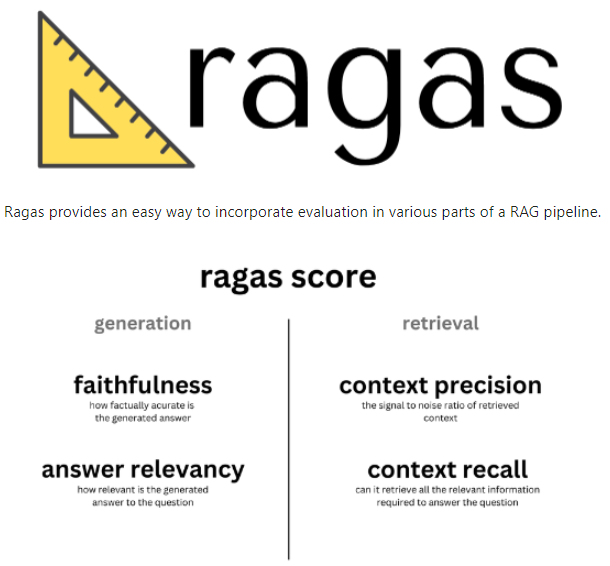

It gives a variety of metric choices, which helps us identify the quality of answers and retrievals. </br>

Lets see Ragas in action.

#### Installation and Imports

##### Description of various installations -
**Langchain** - *Langchain is a framework that helps simplifies the development and production of LLM based applications.* </br>
**OpenAI** - *OpenAI provides us access to the latest GPT models for our analysis. Please note that for this demonstration, you would need an OpenAI key.* </br>
**ChromaDB** - *ChromaDB is an open-source vector store, that facilitates quick storage, and search of text documents.* </br>
**BeautifulSoup4** - *We will use bs4 for scrapping data from the internet, which would serve as our knowledge base.* </br>


In [ ]:
!pip install langchain==0.0.309 ragas==0.0.17 openai==0.28.1 chromadb==0.4.15 beautifulsoup4==4.12.3

In [2]:
import os
import getpass
import pandas as pd
from IPython.display import display, HTML

from langchain.document_loaders import WebBaseLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings

Getpass : An alternate to using env files

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


**Ragas** - *Ragas is the topic of this demo. It is a framework which provides us an easy implementation of various evaluation metrics. </br>
Ragas uses TinyBERT for a cross encoder score in one of its metrics, hence, it also downloads the dependant tokenisers, models and configs from Huggingface*

In [4]:
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
from ragas.langchain import RagasEvaluatorChain

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/517 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
pd.set_option('display.max_colwidth', None)

#### Creating a simple index

*Indexing follows the following guidelines -*</br>

 - **Load**: We need to load our data. We’ll use DocumentLoaders for this.
 - **Split**: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won’t fit in a model’s finite context window.
 - **Store**: We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.

 [Indexing](https://python.langchain.com/docs/use_cases/question_answering/quickstart)

*The function **VectorstoreIndexCreator** uses **ChromaDB** in the backend, to store the index we created.* </br>

In [6]:
loader = WebBaseLoader("https://en.wikipedia.org/wiki/New_York_City")
index = VectorstoreIndexCreator().from_loaders([loader])

#### Creating a Question Answering Chain

*The index is converted into a **retriever**, which is how the top-k chunks are identified and sent to the LLM.* </br>

In [7]:
llm = ChatOpenAI()
retriever=index.vectorstore.as_retriever()
qa_chain = RetrievalQA.from_chain_type(
    llm, retriever=retriever, return_source_documents=True
)

In [8]:
question = "How did New York City get its name?"
result = qa_chain({"query": question})


#### Visualisation of answers and sources

In [9]:
def convert_to_dict(document):
    return {
        'query': result['query'],
        'result': result['result'],
        'source_documents': [document]
    }

In [10]:
result_dicts = []
for doc in result['source_documents']:
    result_dicts.append(convert_to_dict(doc))

In [11]:
result_dicts

[{'query': 'How did New York City get its name?',
  'result': 'New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.',
  'source_documents': [Document(page_content='New York City traces its origins to Fort Amsterdam and a trading post founded on the southern tip of Manhattan Island by Dutch colonists in approximately 1624. The settlement was named New Amsterdam (Dutch: Nieuw Amsterdam) in 1626 and was chartered as a city in 1653. The city came under English control in 1664 and was renamed New York after King Charles II granted the lands to his brother, the Duke of York.[24] The city was temporarily regained by the Dutch in July 1673 and was renamed New Orange; however, the city has been named New York since November 1674. New York City was the capital of the United States from 1785 until 1790

*By default, the chain returns all the source documents as one giant list. For our analysis, it is better to dive further into individual sources.* </br>

In [12]:
question = result['query']
answer = result['result']
source_content = [doc.page_content for doc in result['source_documents']]

df = pd.DataFrame({'Question': [question] * len(source_content), 'Answer': [answer] * len(source_content), 'Sources': source_content})
df

,Question,Answer,Sources
0,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","New York City traces its origins to Fort Amsterdam and a trading post founded on the southern tip of Manhattan Island by Dutch colonists in approximately 1624. The settlement was named New Amsterdam (Dutch: Nieuw Amsterdam) in 1626 and was chartered as a city in 1653. The city came under English control in 1664 and was renamed New York after King Charles II granted the lands to his brother, the Duke of York.[24] The city was temporarily regained by the Dutch in July 1673 and was renamed New Orange; however, the city has been named New York since November 1674. New York City was the capital of the United States from 1785 until 1790.[25] The modern city was formed by the 1898 consolidation of its five boroughs: Manhattan, Brooklyn, Queens, The Bronx, and Staten Island, and has been the largest U.S. city ever since."
1,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","Etymology\nSee also: Nicknames of New York City\nIn 1664, New York was named in honor of the Duke of York (later King James II of England).[33] James's elder brother, King Charles II, appointed the Duke as proprietor of the former territory of New Netherland, including the city of New Amsterdam, when the Kingdom of England seized it from Dutch control.[34]"
2,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Nigro, Carmen. ""So, Why Do We Call It Gotham, Anyway?"", New York Public Library, January 25, 2011. Accessed March 3, 2023. ""It is here that we learn that the term Gotham is tied to the author Washington Irving, famous for his short stories 'The Legend of Sleepy Hollow,' and 'Rip Van Winkle.' It's also here that we learn Irving was being less than flattering when he nicknamed the city in 1807.""\n\n^ ""US Gazetteer files: 2010, 2000, and 1990"". United States Census Bureau. February 12, 2011. Retrieved April 23, 2011.\n\n^ ""ArcGIS REST Services Directory"". United States Census Bureau. Retrieved September 20, 2022.\n\n^ a b c d e f g h i j QuickFacts for New York city, New York; New York; United States, United States Census Bureau. Accessed January 12, 2024.\n\n^ ""List of 2020 Census Urban Areas"". census.gov. United States Census Bureau. Retrieved January 8, 2023.\n\n^ ""2020 Population and Housing State Data"". United States Census Bureau. August 12, 2021. Retrieved November 24, 2021."
3,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Rankin, Rebecca B.; Rodgers, Cleveland (1948). New York: The World's Capital City, Its Development and Contributions to Progress. Harper.\n\n^ WPA Writer's Project (2004). A Maritime History of New York. Going Coastal Productions. p. 246. ISBN 0-9729803-1-8.\n\n^ Lankevich, George J. (2002). New York City: A Short History. NYU Press. p. 2. ISBN 978-0-8147-5186-2.\n\n^ ""The Hudson River"". New Netherland Institute. Retrieved July 10, 2016.\n\n^ Roberts, Sam (October 2, 2012). ""Honoring a Very Early New Yorker"". The New York Times. Retrieved October 28, 2021.\n\n^ ""CUNY DSI Publishes Monograph on New 

#### Creating an Evaluation Chain

*We will be using **RagasEvaluatorChain**, offered by Langchain for this.* </br>
*This evaluation chain, describes the various parameters of the evaluation metrics we are going to use.* </br>
*The way to visualise it, is that **every metric has their own parameters**.* </br>
***Faithfulness**, for example, requires an instance of a GPT model to be passed - we can view the exact model sent, in the cell below.* </br>
***Context Relevancy**, utilises a Huggingface BERT model instance, which can be also seen.* </br>


In [13]:
eval_chains = {}

for metric in [faithfulness, answer_relevancy, context_precision]:
    evaluator_chain = RagasEvaluatorChain(metric=metric)
    eval_chains[metric.name] = evaluator_chain

#### Visualising the Created Chain

In [ ]:
# on running this we get the below output (key is masked)
#eval_chains

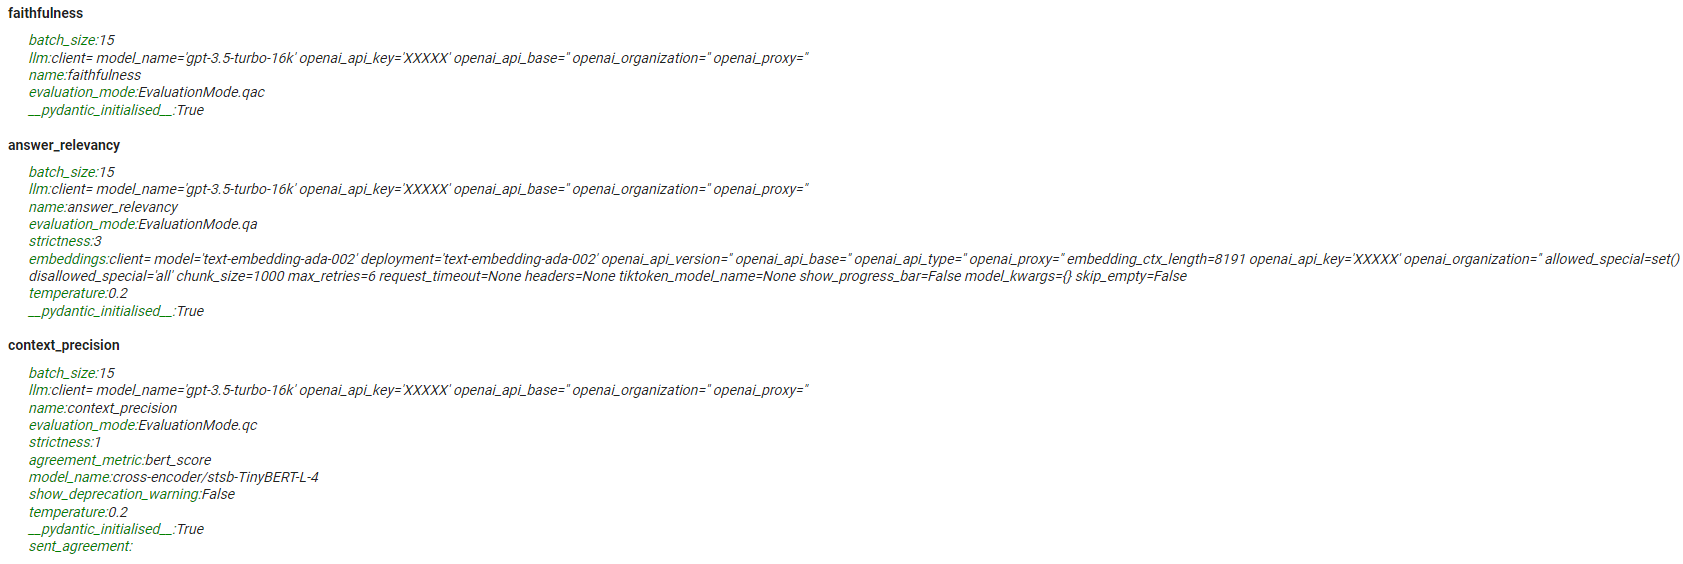

### Let's have a look at the results

In [15]:
for ind, row in df.iterrows():
    context = row['Sources']
    for name, eval_chain in eval_chains.items():
        score_name = f"{name}_score"
        for i, result_dict in enumerate(result_dicts, 1):
            if result_dict['source_documents'][0].page_content == context:
                df.at[ind, score_name] = eval_chain(result_dict)[score_name]
                break
df

,Question,Answer,Sources,faithfulness_score,answer_relevancy_score,context_precision_score
0,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","New York City traces its origins to Fort Amsterdam and a trading post founded on the southern tip of Manhattan Island by Dutch colonists in approximately 1624. The settlement was named New Amsterdam (Dutch: Nieuw Amsterdam) in 1626 and was chartered as a city in 1653. The city came under English control in 1664 and was renamed New York after King Charles II granted the lands to his brother, the Duke of York.[24] The city was temporarily regained by the Dutch in July 1673 and was renamed New Orange; however, the city has been named New York since November 1674. New York City was the capital of the United States from 1785 until 1790.[25] The modern city was formed by the 1898 consolidation of its five boroughs: Manhattan, Brooklyn, Queens, The Bronx, and Staten Island, and has been the largest U.S. city ever since.",0.75,0.925776,0.6
1,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","Etymology\nSee also: Nicknames of New York City\nIn 1664, New York was named in honor of the Duke of York (later King James II of England).[33] James's elder brother, King Charles II, appointed the Duke as proprietor of the former territory of New Netherland, including the city of New Amsterdam, when the Kingdom of England seized it from Dutch control.[34]",0.75,0.915400,0.4
2,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Nigro, Carmen. ""So, Why Do We Call It Gotham, Anyway?"", New York Public Library, January 25, 2011. Accessed March 3, 2023. ""It is here that we learn that the term Gotham is tied to the author Washington Irving, famous for his short stories 'The Legend of Sleepy Hollow,' and 'Rip Van Winkle.' It's also here that we learn Irving was being less than flattering when he nicknamed the city in 1807.""\n\n^ ""US Gazetteer files: 2010, 2000, and 1990"". United States Census Bureau. February 12, 2011. Retrieved April 23, 2011.\n\n^ ""ArcGIS REST Services Directory"". United States Census Bureau. Retrieved September 20, 2022.\n\n^ a b c d e f g h i j QuickFacts for New York city, New York; New York; United States, United States Census Bureau. Accessed January 12, 2024.\n\n^ ""List of 2020 Census Urban Areas"". census.gov. United States Census Bureau. Retrieved January 8, 2023.\n\n^ ""2020 Population and Housing State Data"". United States Census Bureau. August 12, 2021. Retrieved November 24, 2021.",0.00,0.919834,0.0
3,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Rankin, Rebecca B.; Rodgers, Cleveland (1948). New York: The World's Capital City, Its Development and Contributions to Progress. Harper.\n\n^ WPA Writer's Project (2004). A Maritime History of New York. Going Coastal Productions. p. 246. ISBN 0-9729803-1-8.\n\n^ Lankevich, George J. (2002). New York City: A Short History. NYU Press. p. 2. ISBN 978-0-8147-5186-2.\n\n^ ""The Hudson River"". New Netherland Institute. Retrieved July 10, 2016.\n\n^ Roberts, Sam (October 2, 2012). ""Honorin

**Here is a detailed walkthrough of its metrics -** </br>

### Faithfulness

- Compares **Answer** with **Context**
- Good for checking hallucinations, and wrong answers.
- Divides the answer in 'n' claims, where every claim is cross-checked with context.
- Higher the percentage of correct claims more the Faithfulness


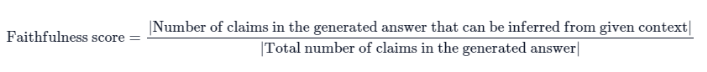


**Example -** </br></br>
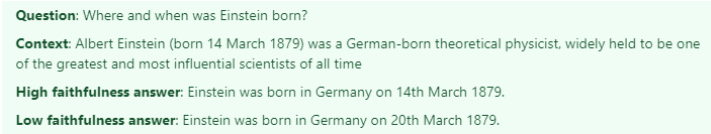

In [16]:
df.drop(columns=["answer_relevancy_score","context_precision_score"])

,Question,Answer,Sources,faithfulness_score
0,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","New York City traces its origins to Fort Amsterdam and a trading post founded on the southern tip of Manhattan Island by Dutch colonists in approximately 1624. The settlement was named New Amsterdam (Dutch: Nieuw Amsterdam) in 1626 and was chartered as a city in 1653. The city came under English control in 1664 and was renamed New York after King Charles II granted the lands to his brother, the Duke of York.[24] The city was temporarily regained by the Dutch in July 1673 and was renamed New Orange; however, the city has been named New York since November 1674. New York City was the capital of the United States from 1785 until 1790.[25] The modern city was formed by the 1898 consolidation of its five boroughs: Manhattan, Brooklyn, Queens, The Bronx, and Staten Island, and has been the largest U.S. city ever since.",0.75
1,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","Etymology\nSee also: Nicknames of New York City\nIn 1664, New York was named in honor of the Duke of York (later King James II of England).[33] James's elder brother, King Charles II, appointed the Duke as proprietor of the former territory of New Netherland, including the city of New Amsterdam, when the Kingdom of England seized it from Dutch control.[34]",0.75
2,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Nigro, Carmen. ""So, Why Do We Call It Gotham, Anyway?"", New York Public Library, January 25, 2011. Accessed March 3, 2023. ""It is here that we learn that the term Gotham is tied to the author Washington Irving, famous for his short stories 'The Legend of Sleepy Hollow,' and 'Rip Van Winkle.' It's also here that we learn Irving was being less than flattering when he nicknamed the city in 1807.""\n\n^ ""US Gazetteer files: 2010, 2000, and 1990"". United States Census Bureau. February 12, 2011. Retrieved April 23, 2011.\n\n^ ""ArcGIS REST Services Directory"". United States Census Bureau. Retrieved September 20, 2022.\n\n^ a b c d e f g h i j QuickFacts for New York city, New York; New York; United States, United States Census Bureau. Accessed January 12, 2024.\n\n^ ""List of 2020 Census Urban Areas"". census.gov. United States Census Bureau. Retrieved January 8, 2023.\n\n^ ""2020 Population and Housing State Data"". United States Census Bureau. August 12, 2021. Retrieved November 24, 2021.",0.00
3,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Rankin, Rebecca B.; Rodgers, Cleveland (1948). New York: The World's Capital City, Its Development and Contributions to Progress. Harper.\n\n^ WPA Writer's Project (2004). A Maritime History of New York. Going Coastal Productions. p. 246. ISBN 0-9729803-1-8.\n\n^ Lankevich, George J. (2002). New York City: A Short History. NYU Press. p. 2. ISBN 978-0-8147-5186-2.\n\n^ ""The Hudson River"". New Netherland Institute. Retrieved July 10, 2016.\n\n^ Roberts, Sam (October 2, 2012). ""Honoring a Very Early New Yorker"". The New York Times. Retrieved October 28, 2021.\n\n^ ""CU

*Lets breakdown the results -*</br>

Some sources get lower faithfulness score due to a few missing parts from the answer. Hence getting lower scores.


Example from an earlier run


*We see that in the **first source**, there is no mention of **New Netherlands**, or Duke being appointed the **proprietor** by the king.*</br>
*The **second source** however, **matches the answer completely**, and is the source the answer used.*</br>
*The **third and fourth sources are irrelevant***</br></br>
*Hence Faithfulness is not only helpful in evaluating answers, but also helpful in evaluating the quality of the returned sources*</br>

### Context Relevancy

- Compares Question with Context.
- Ideally retrieved contexts should be relevant to the question asked.
- **Numerator** -  Here we divide our context into 'n' sentences and check how many sentences are relevant to the question.
- More relevant sentences are better.


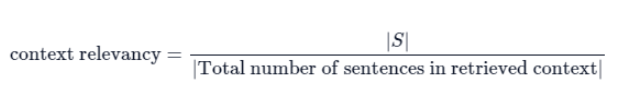


**Example -** </br></br>

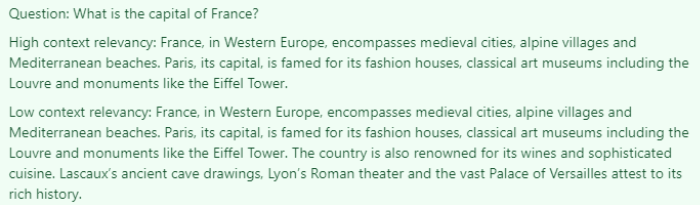

In [18]:
df.drop(columns=["answer_relevancy_score","faithfulness_score"])

,Question,Answer,Sources,context_precision_score
0,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","New York City traces its origins to Fort Amsterdam and a trading post founded on the southern tip of Manhattan Island by Dutch colonists in approximately 1624. The settlement was named New Amsterdam (Dutch: Nieuw Amsterdam) in 1626 and was chartered as a city in 1653. The city came under English control in 1664 and was renamed New York after King Charles II granted the lands to his brother, the Duke of York.[24] The city was temporarily regained by the Dutch in July 1673 and was renamed New Orange; however, the city has been named New York since November 1674. New York City was the capital of the United States from 1785 until 1790.[25] The modern city was formed by the 1898 consolidation of its five boroughs: Manhattan, Brooklyn, Queens, The Bronx, and Staten Island, and has been the largest U.S. city ever since.",0.6
1,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","Etymology\nSee also: Nicknames of New York City\nIn 1664, New York was named in honor of the Duke of York (later King James II of England).[33] James's elder brother, King Charles II, appointed the Duke as proprietor of the former territory of New Netherland, including the city of New Amsterdam, when the Kingdom of England seized it from Dutch control.[34]",0.4
2,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Nigro, Carmen. ""So, Why Do We Call It Gotham, Anyway?"", New York Public Library, January 25, 2011. Accessed March 3, 2023. ""It is here that we learn that the term Gotham is tied to the author Washington Irving, famous for his short stories 'The Legend of Sleepy Hollow,' and 'Rip Van Winkle.' It's also here that we learn Irving was being less than flattering when he nicknamed the city in 1807.""\n\n^ ""US Gazetteer files: 2010, 2000, and 1990"". United States Census Bureau. February 12, 2011. Retrieved April 23, 2011.\n\n^ ""ArcGIS REST Services Directory"". United States Census Bureau. Retrieved September 20, 2022.\n\n^ a b c d e f g h i j QuickFacts for New York city, New York; New York; United States, United States Census Bureau. Accessed January 12, 2024.\n\n^ ""List of 2020 Census Urban Areas"". census.gov. United States Census Bureau. Retrieved January 8, 2023.\n\n^ ""2020 Population and Housing State Data"". United States Census Bureau. August 12, 2021. Retrieved November 24, 2021.",0.0
3,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Rankin, Rebecca B.; Rodgers, Cleveland (1948). New York: The World's Capital City, Its Development and Contributions to Progress. Harper.\n\n^ WPA Writer's Project (2004). A Maritime History of New York. Going Coastal Productions. p. 246. ISBN 0-9729803-1-8.\n\n^ Lankevich, George J. (2002). New York City: A Short History. NYU Press. p. 2. ISBN 978-0-8147-5186-2.\n\n^ ""The Hudson River"". New Netherland Institute. Retrieved July 10, 2016.\n\n^ Roberts, Sam (October 2, 2012). ""Honoring a Very Early New Yorker"". The New York Times. Retrieved October 28, 2021.\n\n^ ""

*So we know now, that the crisper the context is, the better the context precision score is.* </br>
*Lets use a **compression filter** that makes our sources consise.*

##### Contextual Compression

***Contextual compression's** idea is simple - instead of immediately returning retrieved documents as-is, we compress them **using the given query**, so that only the relevant information is returned.* </br>
*We will use **LLMChainExtractor** as the compressor, and the prior designed retriever as the **base retriever.*** </br>


In [22]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

llm = ChatOpenAI()
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

# New chain pointing to compression retriever
qa_compressor_chain = RetrievalQA.from_chain_type(
    llm, retriever=compression_retriever, return_source_documents=True
)
result = qa_compressor_chain({"query": question})

In [23]:
question = result['query']
answer = result['result']
source_content = [doc.page_content for doc in result['source_documents']]
compressed_df = pd.DataFrame({'Question': [question] * len(source_content), 'Answer': [answer] * len(source_content), 'Sources': source_content})
compressed_df

,Question,Answer,Sources
0,How did New York City get its name?,"New York City was named after King Charles II granted the lands to his brother, the Duke of York. The city was named in honor of the Duke of York.","New York City was named after King Charles II granted the lands to his brother, the Duke of York."
1,How did New York City get its name?,"New York City was named after King Charles II granted the lands to his brother, the Duke of York. The city was named in honor of the Duke of York.",New York was named in honor of the Duke of York.
2,How did New York City get its name?,"New York City was named after King Charles II granted the lands to his brother, the Duke of York. The city was named in honor of the Duke of York.","""Sponsored by the West India Company, 30 families arrived in North America in 1624, establishing a settlement on present-day Manhattan."""


Rerunning the chain to see the results of compressed context

In [24]:
compressed_eval_chains = {}

for metric in [faithfulness, answer_relevancy, context_precision]:
    compressed_eval_chain = RagasEvaluatorChain(metric=metric)
    compressed_eval_chains[metric.name] = compressed_eval_chain

In [25]:
compressed_result_dicts = []
for doc in result['source_documents']:
    compressed_result_dicts.append(convert_to_dict(doc))

In [26]:
for ind, row in compressed_df.iterrows():
    context = row['Sources']
    for name, eval_chain in compressed_eval_chains.items():
        score_name = f"{name}_score"
        for i, result_dict in enumerate(compressed_result_dicts, 1):
            if result_dict['source_documents'][0].page_content == context:
                compressed_df.at[ind, score_name] = eval_chain(result_dict)[score_name]
                break


In [27]:
compressed_df.drop(columns=["answer_relevancy_score","faithfulness_score"])

,Question,Answer,Sources,context_precision_score
0,How did New York City get its name?,"New York City was named after King Charles II granted the lands to his brother, the Duke of York. The city was named in honor of the Duke of York.","New York City was named after King Charles II granted the lands to his brother, the Duke of York.",1.0
1,How did New York City get its name?,"New York City was named after King Charles II granted the lands to his brother, the Duke of York. The city was named in honor of the Duke of York.",New York was named in honor of the Duke of York.,1.0
2,How did New York City get its name?,"New York City was named after King Charles II granted the lands to his brother, the Duke of York. The city was named in honor of the Duke of York.","""Sponsored by the West India Company, 30 families arrived in North America in 1624, establishing a settlement on present-day Manhattan.""",0.0


*As expected, the context precision score improves **drastically** when we eliminate the noise from our sources.*

### Answer Relevancy

- Compares **Answer** with **Question**
- Given an answer, it reverse engineers multiple questions, which the answer could have been of.
- Cosine similarity is calculated between the generated questions and the original question.
- Higher the cosine similarity, the more relevant the answer was to the question asked.

**Example -** </br></br>

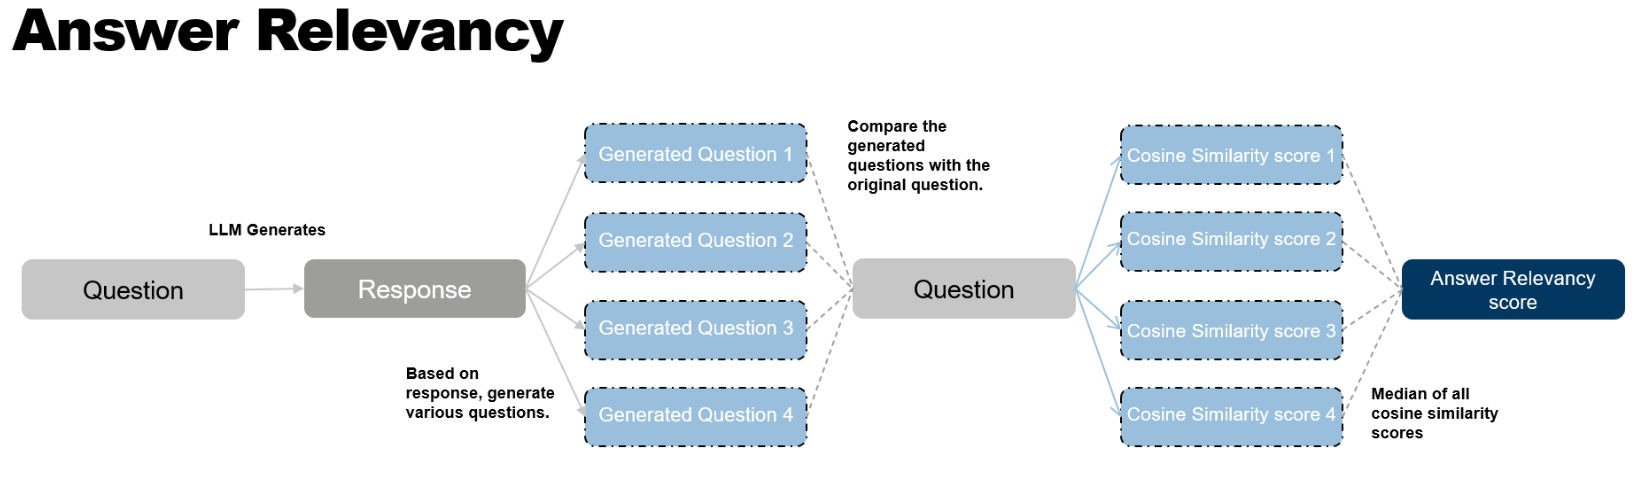

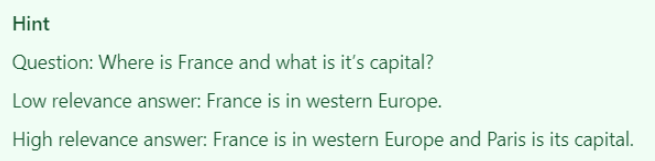

In [29]:
df.drop(columns=["context_precision_score","faithfulness_score"])

,Question,Answer,Sources,answer_relevancy_score
0,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","New York City traces its origins to Fort Amsterdam and a trading post founded on the southern tip of Manhattan Island by Dutch colonists in approximately 1624. The settlement was named New Amsterdam (Dutch: Nieuw Amsterdam) in 1626 and was chartered as a city in 1653. The city came under English control in 1664 and was renamed New York after King Charles II granted the lands to his brother, the Duke of York.[24] The city was temporarily regained by the Dutch in July 1673 and was renamed New Orange; however, the city has been named New York since November 1674. New York City was the capital of the United States from 1785 until 1790.[25] The modern city was formed by the 1898 consolidation of its five boroughs: Manhattan, Brooklyn, Queens, The Bronx, and Staten Island, and has been the largest U.S. city ever since.",0.925776
1,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","Etymology\nSee also: Nicknames of New York City\nIn 1664, New York was named in honor of the Duke of York (later King James II of England).[33] James's elder brother, King Charles II, appointed the Duke as proprietor of the former territory of New Netherland, including the city of New Amsterdam, when the Kingdom of England seized it from Dutch control.[34]",0.915400
2,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Nigro, Carmen. ""So, Why Do We Call It Gotham, Anyway?"", New York Public Library, January 25, 2011. Accessed March 3, 2023. ""It is here that we learn that the term Gotham is tied to the author Washington Irving, famous for his short stories 'The Legend of Sleepy Hollow,' and 'Rip Van Winkle.' It's also here that we learn Irving was being less than flattering when he nicknamed the city in 1807.""\n\n^ ""US Gazetteer files: 2010, 2000, and 1990"". United States Census Bureau. February 12, 2011. Retrieved April 23, 2011.\n\n^ ""ArcGIS REST Services Directory"". United States Census Bureau. Retrieved September 20, 2022.\n\n^ a b c d e f g h i j QuickFacts for New York city, New York; New York; United States, United States Census Bureau. Accessed January 12, 2024.\n\n^ ""List of 2020 Census Urban Areas"". census.gov. United States Census Bureau. Retrieved January 8, 2023.\n\n^ ""2020 Population and Housing State Data"". United States Census Bureau. August 12, 2021. Retrieved November 24, 2021.",0.919834
3,How did New York City get its name?,"New York City got its name in 1664 in honor of the Duke of York (later King James II of England) by King Charles II. This was when the Kingdom of England seized the territory of New Netherland, including the city of New Amsterdam, from Dutch control.","^ Rankin, Rebecca B.; Rodgers, Cleveland (1948). New York: The World's Capital City, Its Development and Contributions to Progress. Harper.\n\n^ WPA Writer's Project (2004). A Maritime History of New York. Going Coastal Productions. p. 246. ISBN 0-9729803-1-8.\n\n^ Lankevich, George J. (2002). New York City: A Short History. NYU Press. p. 2. ISBN 978-0-8147-5186-2.\n\n^ ""The Hudson River"". New Netherland Institute. Retrieved July 10, 2016.\n\n^ Roberts, Sam (October 2, 2012). ""Honoring a Very Early New Yorker"". The New York Times. Retrieved October 28,

***Answer relevancy** compares the answer to the question, and as the same answer-question combination is being sent everytime, we expect, and also see that the relevancy is **consitent** everytime.*

In [ ]:
compressed_df.drop(columns=["context_precision_score","faithfulness_score"])

,Question,Answer,Sources,answer_relevancy_score
0,How did New York City get its name?,"New York City was named after the Duke of York, who later became King James II of England.","New York City traces its origins to Fort Amsterdam and a trading post founded on the southern tip of Manhattan Island by Dutch colonists in approximately 1624. The settlement was named New Amsterdam (Dutch: Nieuw Amsterdam) in 1626 and was chartered as a city in 1653. The city came under English control in 1664 and was renamed New York after King Charles II granted the lands to his brother, the Duke of York.",0.932846
1,How did New York City get its name?,"New York City was named after the Duke of York, who later became King James II of England.",New York was named in honor of the Duke of York (later King James II of England).,0.932846


*We even see the consistency in the metric response, when we see work with Compressed contexts.*

### Context Recall
- Compares **Ground Truth** with **Context**
- Similar to Context relevancy in calculations
- Iterates through total sentences in the ground truth, comparing them to the context.
- More the sentences matched to the context, higher the score.

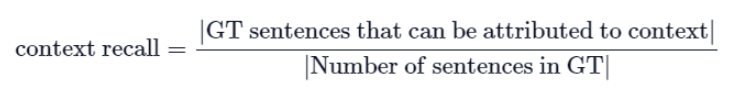

**Example -** </br></br>

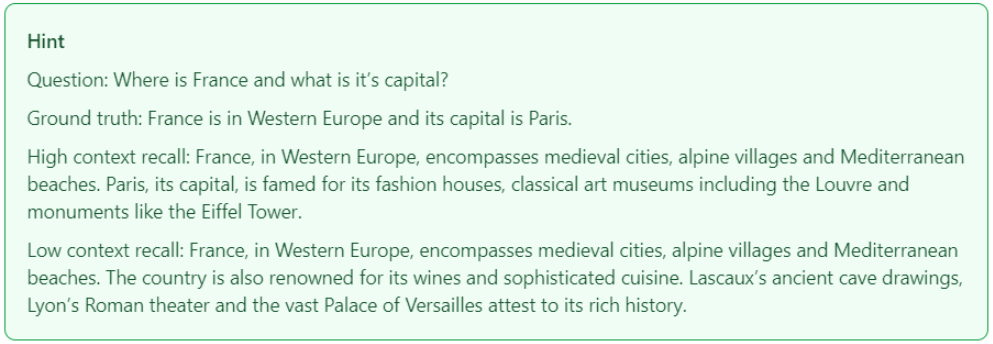

In [30]:
eval_chains = {
    m.name: RagasEvaluatorChain(metric=m)
    for m in [context_recall]
}

In [41]:
eval_questions = [
    "What is the population of New York City as of 2020?",
    "Which borough of New York City has the highest population?",
    "What is the economic significance of New York City?",
    "How did New York City get its name?",
    "What is the significance of the Statue of Liberty in New York City?",
]

eval_truths = [
    "8,800", # incorrect answer
    "Upper West Side",    # incorrect answer
    "New York City's economic significance is vast, as it serves as the global financial capital, housing Wall Street and major financial institutions. Its diverse economy spans technology, media, healthcare, education, and more, making it resilient to economic fluctuations. NYC is a hub for international business, attracting global companies, and boasts a large, skilled labor force. Its real estate market, tourism, cultural industries, and educational institutions further fuel its economic prowess. The city's transportation network and global influence amplify its impact on the world stage, solidifying its status as a vital economic player and cultural epicenter.",
    "New York City got its name when it came under British control in 1664. King Charles II of England granted the lands to his brother, the Duke of York, who named the city New York in his own honor.",
    'The Statue of Liberty in New York City holds great significance as a symbol of the United States and its ideals of liberty and peace. It greeted millions of immigrants who arrived in the U.S. by ship in the late 19th and early 20th centuries, representing hope and freedom for those seeking a better life. It has since become an iconic landmark and a global symbol of cultural diversity and freedom.',
]


In [42]:
eval_answers = []
eval_sources = []

In [43]:
for i, q in enumerate(eval_questions):
    result = qa_chain({"query": q})
    eval_answers.append(result['result'])
    eval_sources.append([doc for doc in result['source_documents']])

In [44]:
examples = [{"query": q, "ground_truths": [eval_truths[i]], "result": eval_answers[i], "source_documents": eval_sources[i]}
           for i, q in enumerate(eval_questions)]

In [45]:
cr_df = pd.DataFrame(examples)

In [46]:
cr_df

query  \
0                  What is the population of New York City as of 2020?   
1           Which borough of New York City has the highest population?   
2                  What is the economic significance of New York City?   
3                                  How did New York City get its name?   
4  What is the significance of the Statue of Liberty in New York City?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ground_truths  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        [8,800]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [Upper West Side]   
2  [New York City's economic significance is vast, as it serves as the global financial capital, housing Wall Street and major financial institutions. Its diverse economy spans technology, media, healthcare, education, and more, making it resilient to economic fluctuations. NYC is a hub for international business, attracting global companies, and boasts a large, skilled labor force. Its real estate market, tourism, cultural industries, and educational institutions further fuel its economic prowess. The city's transportation network and global influence amplify its impact on the world stage, solidifying its status as a vital economic player and cultural epicenter.]   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [New York City got its name when it came under British control in 1664. King Charles II of England granted the lands to his brother, the Duke of York, who named the city New York in his own honor.]   
4                                                                                                                                                                                                                                               

In [47]:
# Run the eval chain for context recall metric on each row of the above table... Takes question, answer, ground truth and returns the recall rate
for name, eval_chain in eval_chains.items():
    score_name = f"{name}_score"
    for i, examples_dict in enumerate(examples, 0):
        cr_df.at[i, score_name] = eval_chain(examples_dict)[score_name]


In [48]:
eval_chain(examples_dict)

{'query': 'What is the significance of the Statue of Liberty in New York City?',
 'ground_truths': ['The Statue of Liberty in New York City holds great significance as a symbol of the United States and its ideals of liberty and peace. It greeted millions of immigrants who arrived in the U.S. by ship in the late 19th and early 20th centuries, representing hope and freedom for those seeking a better life. It has since become an iconic landmark and a global symbol of cultural diversity and freedom.'],
 'result': 'The Statue of Liberty in New York City is a symbol of the United States and its ideals of liberty, freedom, and opportunity. It was dedicated in 1886 and welcomed millions of immigrants to the U.S. via Ellis Island in the late 19th and early 20th centuries. It represents American ideals of liberty and peace.',
 'source_documents': [Document(page_content="Late 19th and early 20th century\nMain articles: History of New York City (1898‚Äì1945) and History of New York City (1946‚Äì19

In [49]:
cr_df

query  \
0                  What is the population of New York City as of 2020?   
1           Which borough of New York City has the highest population?   
2                  What is the economic significance of New York City?   
3                                  How did New York City get its name?   
4  What is the significance of the Statue of Liberty in New York City?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ground_truths  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        [8,800]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [Upper West Side]   
2  [New York City's economic significance is vast, as it serves as the global financial capital, housing Wall Street and major financial institutions. Its diverse economy spans technology, media, healthcare, education, and more, making it resilient to economic fluctuations. NYC is a hub for international business, attracting global companies, and boasts a large, skilled labor force. Its real estate market, tourism, cultural industries, and educational institutions further fuel its economic prowess. The city's transportation network and global influence amplify its impact on the world stage, solidifying its status as a vital economic player and cultural epicenter.]   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [New York City got its name when it came under British control in 1664. King Charles II of England granted the lands to his brother, the Duke of York, who named the city New York in his own honor.]   
4                                                                                                                                                                                                                                               